<img style="max-width:20em; height:auto;" src="../graphics/A-Little-Book-on-Adversarial-AI-Cover.png"/>

Author: Nik Alleyne   
Author Blog: https://www.securitynik.com   
Author GitHub: github.com/securitynik   

Author Other Books: [   

            "https://www.amazon.ca/Learning-Practicing-Leveraging-Practical-Detection/dp/1731254458/",   
            
            "https://www.amazon.ca/Learning-Practicing-Mastering-Network-Forensics/dp/1775383024/"   
        ]   


This notebook ***(fgsm_manual.ipynb)*** is part of the series of notebooks From ***A Little Book on Adversarial AI***  A free ebook released by Nik Alleyne

### Fast Gradient Sign Method (FGSM) the Manual Way

Let's load some test data.   
We will use this to ensure we only have samples that are malware, as these labels we would like to flip. 

This should make our understanding of FGSM a lot easier.   

### Step 1:    
Get our data   

In [1]:
# Import libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime as dt

import sklearn
from sklearn.model_selection import train_test_split

In [2]:
### Version of key libraries used  
print(f'Torch version used:  {torch.__version__}')
print(f'Numpy version used:  {np.__version__}')
print(f'Sklearn version used:  {sklearn.__version__}')


Torch version used:  2.7.1+cu128
Numpy version used:  2.1.3
Sklearn version used:  1.7.0


In [3]:
# Setup the device to work with
# This should ensure if there are accelerators in place, such as Apple backend or CUDA, 
# we should be able to take advantage of it.

if torch.cuda.is_available():
    print('Setting the device to cuda')
    device = 'cuda'
elif torch.backends.mps.is_available():
    print('Setting the device to Apple mps')
    device = 'mps'
else:
    print('Setting the device to CPU')
    device = torch.device('cpu')

Setting the device to cuda


In [4]:
# I am going to cheat here. 
# I seem to be running into a problem with my GPU and backpropagation. 
# So to address that, I am forcing this to use CPU.
# You can test on your system by commenting out this line below and running the code
# However, without the GPU this works just fine!
device = 'cpu'

In [5]:
# Load the test set
# This is from the Tiny Malware
X_y = np.load(r'../data/tiny_mal_net_X_y_test.npz', allow_pickle=False)
X = X_y['X']
y = X_y['y']

# Get the shape of the dataset
X.shape, y.shape

((1000, 256), (1000,))

In [6]:
# Get a sample from X
X[0]

array([0., 1., 1., 0., 1., 1., 0., 0., 1., 0., 1., 0., 1., 0., 1., 0., 0.,
       0., 1., 0., 0., 1., 1., 1., 1., 1., 0., 0., 1., 0., 0., 0., 1., 0.,
       1., 1., 1., 1., 0., 1., 1., 1., 0., 1., 1., 0., 1., 0., 0., 1., 1.,
       0., 0., 1., 1., 1., 1., 0., 1., 1., 0., 1., 0., 0., 0., 1., 1., 1.,
       1., 1., 1., 1., 0., 0., 1., 1., 0., 1., 1., 1., 1., 0., 1., 0., 0.,
       1., 0., 1., 0., 1., 1., 1., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0.,
       0., 1., 1., 0., 0., 1., 0., 1., 1., 0., 0., 1., 1., 1., 1., 0., 0.,
       0., 0., 1., 0., 0., 0., 1., 0., 0., 1., 1., 0., 0., 1., 1., 0., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1., 1., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 0., 0., 1., 1., 1., 0., 1., 1., 1., 0., 0., 1., 0.,
       1., 0., 1., 0., 1., 0., 1., 0., 1., 1., 0., 1., 1., 1., 1., 0., 0.,
       1., 0., 1., 1., 1., 1., 1., 1., 0., 0., 1., 0., 1., 0., 0., 0., 0.,
       1., 1., 1., 1., 0.

In [7]:
# Get the min and max value for X
X.min(), X.max()

(np.float32(0.0), np.float32(1.0))

In [8]:
# Convert both the feature and targets to torch tensors
# These currently have dimensions (1, 1, 256, 256) -> (batch_size, channels, height, width)
X = torch.tensor(X.reshape(-1, 1, 16, 16), dtype=torch.float32)

# Convert the labels also to torch tensors
y = torch.tensor(y, dtype=torch.long)

In [9]:
# Get the shape of the X
print(f'The malware samples have a shape of: {X.size()}')

The malware samples have a shape of: torch.Size([1000, 1, 16, 16])


In [10]:
# Malware labels
malware_labels = ['addisplay', 'adware', 'benign', 'downloader', 'trojan']
malware_labels

['addisplay', 'adware', 'benign', 'downloader', 'trojan']

### Step 2:   
Visualize some of the samples   

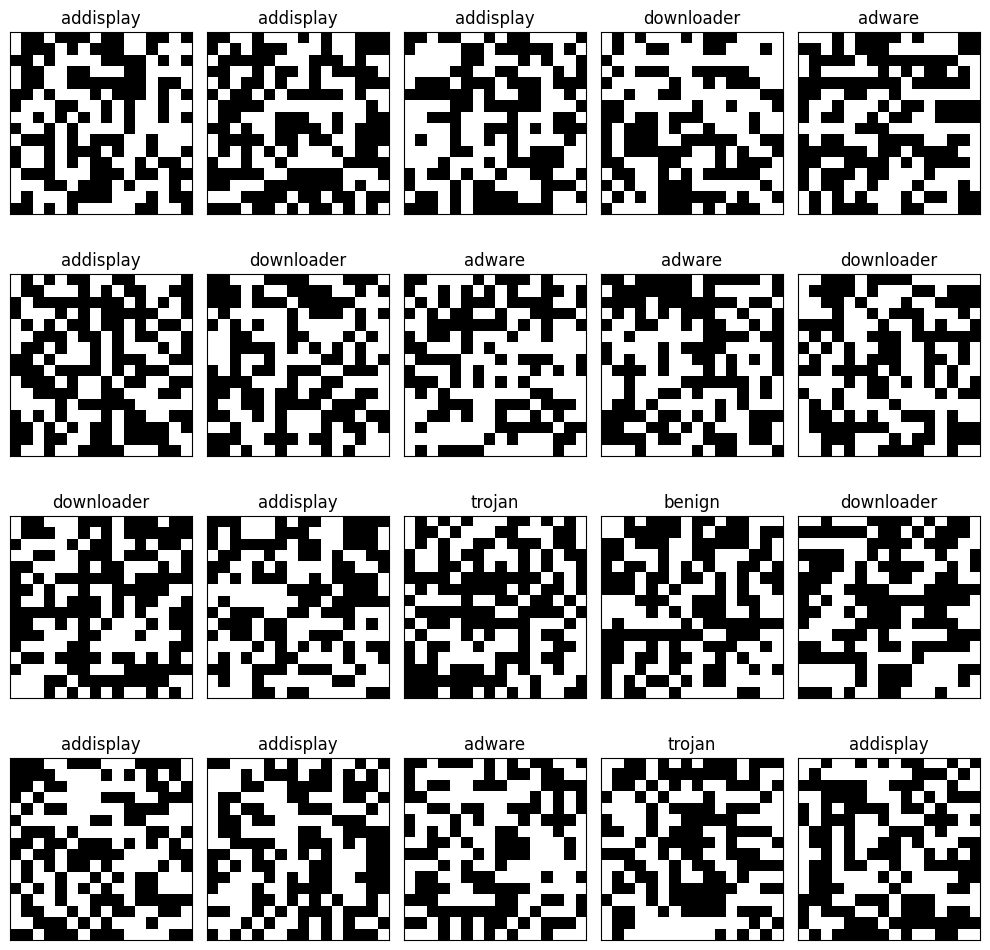

In [11]:
# With all of this in place let's visualize a few samples
# You can adjust the size here
tmp_indicies = np.random.randint(low=0, high=len(X), size=(20))

plt.figure(figsize=(10, 10))
for idx, value in enumerate(tmp_indicies):
    # Adjust the 4,5 here, if you changed the size above
    # Ensure it is a multiple of size
    ax = plt.subplot(4,5,idx+1)
    ax.set_title(label=malware_labels[y[value.item() ].item()  ])
    ax.imshow(X=X[value].reshape(16, -1), cmap='gray')
    plt.xticks([])
    plt.yticks([])

plt.tight_layout()

### Step 4: 
Doing FGSM the hard way :-D 

With the malware samples in place, let us now get to learning FGSM.  

1. Take a legitimate sample, for example our malware   
2. Specify an epsilon value. In the image below, that value is 0.007  
   This value should be very small, so as to make the change imperceptible to the human eye.   
   In order words, the adversarial example should look no different than the original image 
   In traditional Gradient Descent, we want to minimize the loss and thus goes in the negative / opposite direction of the gradient. 
   With the FGSM attack, we want to maximize the loss, hence we go in the direction of the gradient The gradient tells us the direction of steepest ascent. This 0.007 tells us how much to step by.
3. Calculate the gradient of the loss with respect to the input image.   
   In normal neural networks, we take the loss with respect to the parameters (weights and bias) and not the input data  
4. With the gradients in hand, we then take the sign of the gradients.  
   Finding the sign simply means if a value is greater than 0, we make it +1. if the value is negative, we make it -1 if it is 0, we keep it at 0  
   The sign gives the direction of the gradient   
5. Finally, we take the original input, add the epsilon and multiply it by the sign of the gradients. This is now our adversarial example  

<img src="../graphics/fgsm.png" alt="FGSM" width="800"/>   

perturbed_image=original_image + epsilon ∗ sign(data_grad) = x+ϵ∗sign(∇ x J(θ,x,y))


Reference:  
https://arxiv.org/pdf/1412.6572   


In [12]:
# Here are a few examples of finding the sign of a few numbers, you can try a few of your own
print(f'The sign of -1 is: {torch.sign(torch.tensor(-1.))}')
print(f'The sign of 0 is: {torch.sign(torch.tensor(0.))}')
print(f'The sign of 1 is: {torch.sign(torch.tensor(1.))}')
print(f'The sign of -10 is: {torch.sign(torch.tensor(-10.))}')
print(f'The sign of 0.5 is: {torch.sign(torch.tensor(0.5))}')
print(f'The sign of 99 is: {torch.sign(torch.tensor(99.))}')

The sign of -1 is: -1.0
The sign of 0 is: 0.0
The sign of 1 is: 1.0
The sign of -10 is: -1.0
The sign of 0.5 is: 1.0
The sign of 99 is: 1.0


### Step 5:   
Define hyperparameters and load the trained model   

In [13]:
# Define some hyperparameters 
batch_size = 32
hidden_chnls = 8
num_classes = 1
num_epochs = 5
kernel_size = 4
stride = 2
pool_size = 2
linear_dims = 128

In [14]:
# Let's load the model we will target
loaded_malware_classifier = torch.jit.load(r'../data/mal_net_tiny_malware_clf.jit', map_location=device)
loaded_malware_classifier.eval()

RecursiveScriptModule(
  original_name=MalClassifier
  (conv_layers): RecursiveScriptModule(
    original_name=Sequential
    (0): RecursiveScriptModule(original_name=Conv2d)
    (1): RecursiveScriptModule(original_name=BatchNorm2d)
    (2): RecursiveScriptModule(original_name=ReLU)
    (3): RecursiveScriptModule(original_name=Conv2d)
    (4): RecursiveScriptModule(original_name=BatchNorm2d)
    (5): RecursiveScriptModule(original_name=ReLU)
    (6): RecursiveScriptModule(original_name=Conv2d)
    (7): RecursiveScriptModule(original_name=BatchNorm2d)
    (8): RecursiveScriptModule(original_name=ReLU)
  )
  (global_avg_pool): RecursiveScriptModule(original_name=AdaptiveAvgPool2d)
  (classifier): RecursiveScriptModule(original_name=Conv2d)
)

In [15]:
# To see the model state dict
loaded_malware_classifier.state_dict()

# To see a snapshot of layer 0 weight
loaded_malware_classifier.state_dict()['conv_layers.0.weight']

tensor([[[[ 0.0516, -0.2070,  0.2670],
          [-0.0798, -0.0059,  0.1894],
          [ 0.2832, -0.3191, -0.2044]]],


        [[[ 0.2782, -0.3018, -0.1991],
          [ 0.2677, -0.1860,  0.1973],
          [-0.0064, -0.0209,  0.0271]]],


        [[[ 0.0901, -0.3728,  0.1607],
          [-0.1020,  0.2822, -0.1377],
          [-0.0504, -0.1604,  0.2300]]],


        [[[ 0.2506, -0.0527,  0.2107],
          [-0.1103, -0.2593,  0.2187],
          [-0.1559, -0.1288, -0.1126]]],


        [[[-0.1090, -0.0401, -0.2382],
          [ 0.0823,  0.0235,  0.1842],
          [-0.2719,  0.1790,  0.2024]]],


        [[[-0.3066,  0.2604, -0.1717],
          [-0.2340, -0.2157, -0.1990],
          [-0.0120,  0.0674,  0.2876]]],


        [[[ 0.1912,  0.1662, -0.3866],
          [ 0.3626, -0.1671,  0.1218],
          [ 0.2192, -0.0371,  0.0791]]],


        [[[ 0.2232,  0.2194,  0.1586],
          [-0.2301,  0.1602, -0.0401],
          [-0.2614, -0.2821,  0.2480]]],


        [[[-0.1926,  0.2238,  0.

### Step 6:  
Make predictions on the real data

In [16]:
# Get the real predictions
y_real_preds = loaded_malware_classifier(torch.as_tensor(X, dtype=torch.float32, device=device)).argmax(dim=-1)
y_real_preds[:10]

tensor([2, 2, 1, 1, 1, 1, 4, 2, 3, 4])

In [17]:
# Get the accuracy
(y_real_preds.cpu() == y).sum() / len(y)

tensor(0.8700)

On the real test data, we have 87% accuracy. Not bad so far

We are using a model that has already been trained. This means, we will not modify the parameters. The weights remain constant. We will instead find the derivatives of the loss with respect to the input rather than the model weights.   

Now that we have a target model, we want to pass our input image through this model *loaded_malware_clf(X)* to make predictions.   

We then compute the loss based on the predicted class *loss_fn(input=prediction, target=true_label)*   
Compute the gradients of the loss with respect to the input image *loss.backward* <- This is backpropagation occurring  
Create the adversarial example by multiplying the sign of the gradients by the epsilon and add them to the orignal image.  
Finally, we feed the adversarial example to the model and observe the predictions. Let's do that     

### Step 7:  
Define the FGSM function   


In [18]:
# Define the loss function
loss_fn = torch.nn.CrossEntropyLoss()
loss_fn

CrossEntropyLoss()

In [19]:
# Let's define a function for the FGSM atack   
# https://arxiv.org/pdf/1607.02533
# https://github.com/peyman-paknezhad/Adversarial-Robustness-in-Neural-Networks-Implementation-and-Assessment-of-FGSM-BIM-and-PGD-Attacks/blob/main/Adversarial_Robustness_in_Neural_Networks_Implementation_and_Assessment_of_FGSM%2C_BIM%2C_and_PGD_Attacks.ipynb
def fgsm_attack(model=None, X=None, y=None, eps=None):
        
    # Move values to the device  
    X, y = X.to(device=device), y.to(device=device)

    # Ensure the model is in evaluation mode
    model = model.to(device)
    model.eval()

    # Set the requires_grad to True
    # By default, the data is not set to require gradients
    X = X.detach().clone().requires_grad_(True)

    # Get the predictions of the output class
    y_preds = model(X)
    
    # Use the Crossentropy loss
    loss = loss_fn(input=y_preds, target=y)

    # Zero out any gradients that are already there    
    model.zero_grad(set_to_none=True)

    # Perform backpropagation 
    loss.backward()

    # If you wish to see the gradients before the sign uncomment the line below
    #print(f'Gradients before sign: {X.grad.data}')

    # Get the sign of the gradients
    gradients = X.grad.sign()

    # If you wish to see the sign of the gradients uncomment the line below
    #print(f'Gradients after sign: {gradients}')

    # Perturb the gradients
    perturbations = eps * gradients

    # Finally the adversarial example
    adv_examples = X + perturbations

    # Clamp the adversarial sample between 0 and 1
    # Our original input samples are 0 and 1
    # Clipping these values between 0 and 1 ensures we stay within that range
    adv_examples = torch.clamp(adv_examples, min=0, max=1)

    # Return the final example and the perturbations, so we can see what both looks like
    return ( adv_examples, perturbations )


In [20]:
# Declare a variable for epsilon
eps = 0.002
eps

0.002

In [21]:
# The function returns the adversarial example and the perturbations
adversarial_examples, perturb_grad = fgsm_attack(model=loaded_malware_classifier, X=X, y=y, eps=eps)

# Take a sneak peak at the first adversarial example
adversarial_examples[0]

tensor([[[0.0000, 1.0000, 1.0000, 0.0000, 0.9980, 0.9980, 0.0020, 0.0000,
          1.0000, 0.0000, 0.9980, 0.0000, 0.9980, 0.0020, 1.0000, 0.0020],
         [0.0020, 0.0020, 0.9980, 0.0020, 0.0000, 0.9980, 0.9980, 1.0000,
          0.9980, 1.0000, 0.0020, 0.0020, 0.9980, 0.0020, 0.0020, 0.0000],
         [0.9980, 0.0020, 1.0000, 0.9980, 1.0000, 0.9980, 0.0000, 0.9980,
          1.0000, 1.0000, 0.0020, 0.9980, 1.0000, 0.0020, 0.9980, 0.0000],
         [0.0000, 1.0000, 1.0000, 0.0000, 0.0000, 0.9980, 0.9980, 0.9980,
          0.9980, 0.0000, 0.9980, 0.9980, 0.0000, 1.0000, 0.0020, 0.0000],
         [0.0000, 0.9980, 0.9980, 1.0000, 1.0000, 1.0000, 0.9980, 1.0000,
          0.0020, 0.0000, 0.9980, 1.0000, 0.0000, 1.0000, 1.0000, 0.9980],
         [1.0000, 0.0000, 1.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.9980,
          0.0020, 0.9980, 1.0000, 0.9980, 0.0020, 0.0020, 0.9980, 0.9980],
         [0.0020, 0.0020, 0.0000, 0.0020, 0.0020, 0.0020, 0.0020, 0.9980,
          1.0000, 0.0020, 0.0020

In [22]:
# Let's see what this looks like
# As shown below, we have 1 batch of 1 channel with a height of 256 and a width of 256
# For plotting we will need to reshape this
print(f'Shape of the adversarial example is: {adversarial_examples.size()}')

Shape of the adversarial example is: torch.Size([1000, 1, 16, 16])


In [23]:
# Make inference on the adversarial examples
with torch.inference_mode(mode=True):
    adversarial_logits = loaded_malware_classifier(adversarial_examples)
    adversarial_predictions = torch.argmax(input=adversarial_logits, dim=-1)

In [24]:
# What is the accuracy on our adversarial examples?
(adversarial_predictions.cpu() == y).sum() / len(adversarial_examples)

tensor(0.8450)

In [25]:
# What is the adversarial success rate?
# As in how many labels were we able to flip
(y != adversarial_predictions.cpu()).sum() / len(adversarial_predictions)

tensor(0.1550)

In [26]:
# Make a prediction on the adersarial example
# We see the sample is classified as benign.
# Remember, this sample is from the known malware set
#with torch.inference_mode(mode=True):
#    loaded_malware_classifier.eval()
#    prediction = loaded_malware_classifier(adv_example[:1].argmax(dim=-1))
    #print(f'[*] {dt.now()} MALWARE' if prediction.item() == 1 else f'{dt.now()} Looks Normal')
    #print(f'Model predicted: {prediction.item():.4f}')
    #print(f'When rounded the class is: {int(prediction.round().item())}')


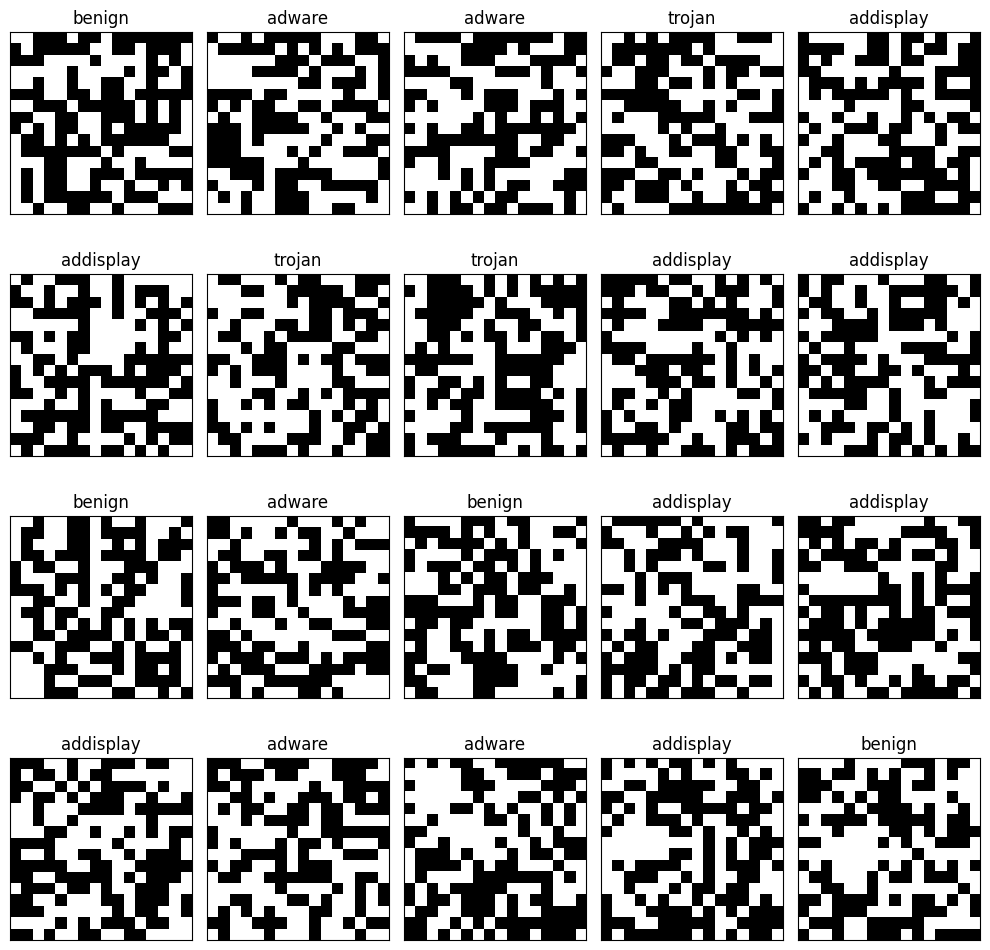

In [27]:
# With all of this in place let's visualize a few samples
# You can adjust the size here
tmp_indicies = np.random.randint(low=0, high=len(adversarial_examples), size=(20))

plt.figure(figsize=(10, 10))
for idx, value in enumerate(tmp_indicies):
    # Adjust the 4,5 here, if you changed the size above
    # Ensure it is a multiple of size
    ax = plt.subplot(4,5,idx+1)
    ax.set_title(label=malware_labels[y[value.item() ].item() ])
    ax.imshow(X=adversarial_examples.cpu()[value].detach().numpy().reshape(16, -1), cmap='gray')
    plt.xticks([])
    plt.yticks([])

plt.tight_layout()

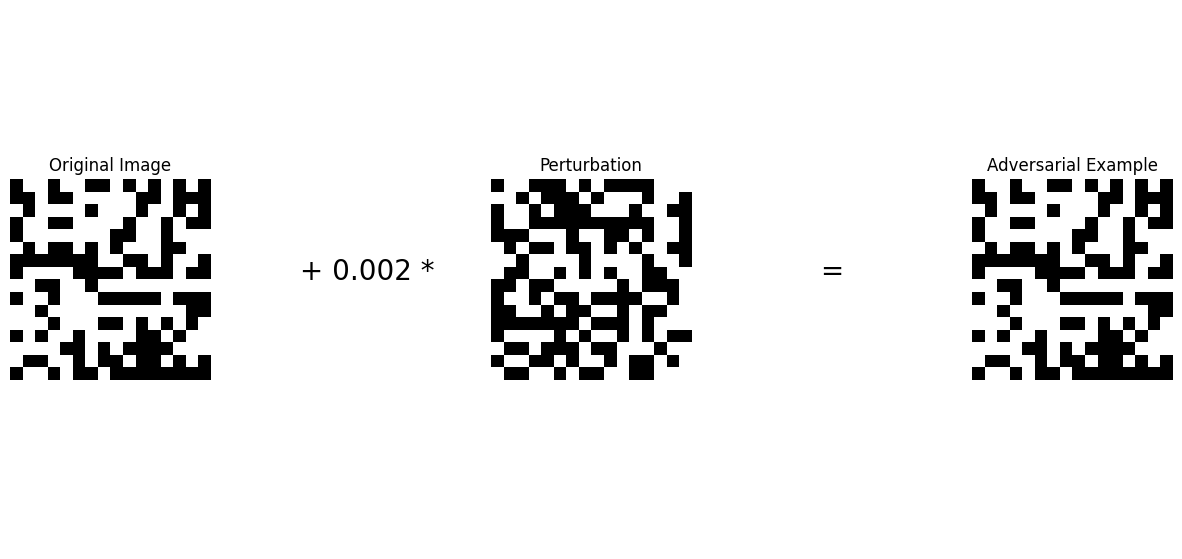

In [28]:
# We can now go ahead and plot the original image and the adversarial example
fig = plt.figure(figsize=(15,7))
ax = fig.add_subplot(1,5,1)

# Detach is called because we calculated gradients
# By detaching we are no removing the need to backpropagate
ax.imshow(X[0].detach().squeeze(dim=0).squeeze(dim=0), cmap='gray')
ax.set_axis_off()
ax.set_title(label='Original Image')

# Add the text
ax = fig.add_subplot(1,5,2)
ax.text(x=.2, y=.5, s=f' + {eps} * ', fontdict={'size' : 20 })
ax.set_axis_off()

# The perturbations are the gradients
ax = fig.add_subplot(1,5,3)
ax.imshow(perturb_grad.cpu()[0].detach().squeeze(dim=0).squeeze(dim=0), cmap='gray')
ax.set_axis_off()
ax.set_title(label='Perturbation')

# Add the text
ax = fig.add_subplot(1,5,4)
ax.text(x=.4, y=.5, s=f' = ', fontdict={'size' : 20 })
ax.set_axis_off()

ax = fig.add_subplot(1,5,5)
# Detach is called because we calculated gradients
# By detaching we are no removing the need to backpropagate
ax.imshow(adversarial_examples.cpu()[0].detach().numpy().squeeze(), cmap='gray')
ax.set_axis_off()
ax.set_title(label='Adversarial Example');

In [29]:
# Previously we used an EPS value of 
eps

0.002

In [30]:
# Let's try a few examples to see how the model performances
eps_values = [0, 0.01, 0.02, 0.002, 0.001, 0.007, 0.07, 0.59, 1]
eps_values

[0, 0.01, 0.02, 0.002, 0.001, 0.007, 0.07, 0.59, 1]

In [31]:
# Creating a function to help validating mutiple samples
# We currently have
print(f'We have {adversarial_examples.size(dim=0)} malware samples')

We have 1000 malware samples


In [32]:
# Try multiple eps values, to check the prediction, adversarial success and overall accuracy
accuracy_tracker = []
adversarial_success = []
predictions = []

for eps in eps_values:
    adv_examples, _ = fgsm_attack(model=loaded_malware_classifier, X=X, y=y, eps=eps)
    with torch.inference_mode(mode=True):
        model_prediction = loaded_malware_classifier(adv_examples).round()

        accuracy = (model_prediction.argmax(dim=-1) == y).sum() / y.size(dim=0)
        accuracy_tracker.append(accuracy)
        adversarial_success.append(1 - accuracy)
        print(f'For eps: {eps} -> Model Accuracy: {accuracy:.3f} \t adversarial accuracy: {1 - accuracy:.3f}')

For eps: 0 -> Model Accuracy: 0.843 	 adversarial accuracy: 0.157
For eps: 0.01 -> Model Accuracy: 0.665 	 adversarial accuracy: 0.335
For eps: 0.02 -> Model Accuracy: 0.496 	 adversarial accuracy: 0.504
For eps: 0.002 -> Model Accuracy: 0.803 	 adversarial accuracy: 0.197
For eps: 0.001 -> Model Accuracy: 0.826 	 adversarial accuracy: 0.174
For eps: 0.007 -> Model Accuracy: 0.718 	 adversarial accuracy: 0.282
For eps: 0.07 -> Model Accuracy: 0.003 	 adversarial accuracy: 0.997
For eps: 0.59 -> Model Accuracy: 0.005 	 adversarial accuracy: 0.995
For eps: 1 -> Model Accuracy: 0.171 	 adversarial accuracy: 0.829


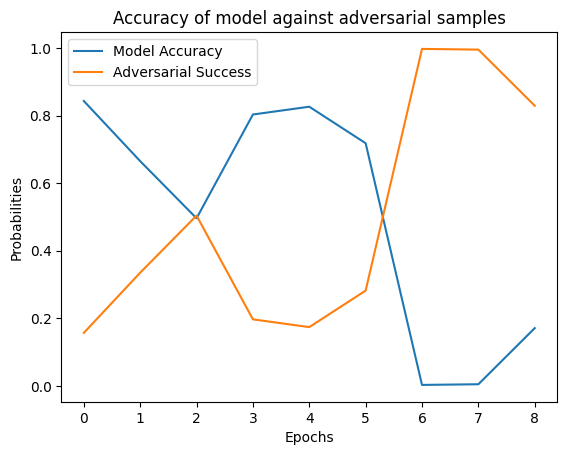

In [33]:
# plot the different eps values
plt.title('Accuracy of model against adversarial samples')
plt.plot(accuracy_tracker, label='Model Accuracy')
plt.plot(adversarial_success, label='Adversarial Success')
plt.xlabel('Epochs')
plt.ylabel('Probabilities')
plt.legend()
plt.show()


In [34]:
# With the training finish clear the GPU cache
# Setup the device to work with
if torch.cuda.is_available():
    # For CUDA GPU
    print(f'Cleaning {device} cache')
    torch.cuda.empty_cache()
elif torch.backends.mps.is_available():
    # For Apple devices
    print(f'Cleaning {device} cache')
    torch.mps.empty_cache()
else:
    # Default to cpu
    pass

Cleaning cpu cache


Wee above that the model is not very robust to the adversarial examples. The accuracy of the model has dropped significantly based on the EPS

### Lab Takeaways:  
- We were able to build the FGSM algorithm from scratch   
- We saw that the value of eps can play a significant role in the adversarial success 